Dreaming: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


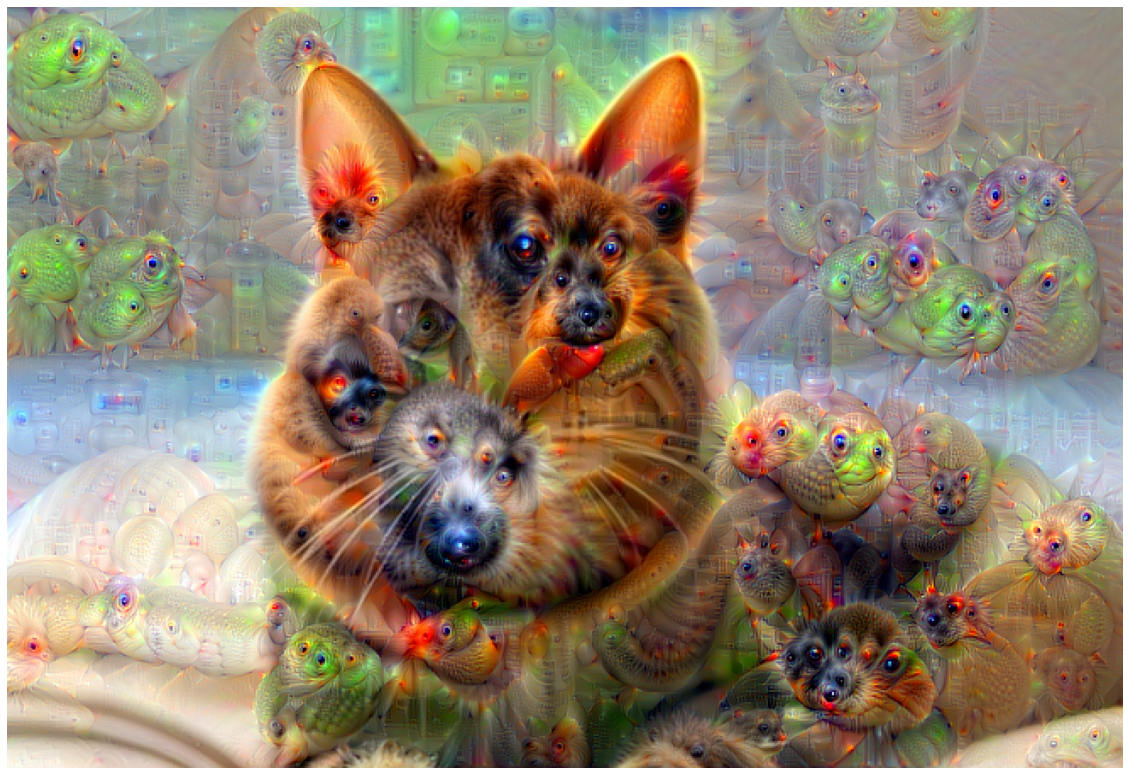

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import tqdm
import scipy.ndimage as nd
from torchvision import transforms

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

def deprocess(image_np):
    image_np = image_np.squeeze().transpose(1, 2, 0)
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image_np = np.clip(image_np, 0.0, 255.0)
    return image_np


def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

def dream(image, model, iterations, lr):
    """ Updates the image to maximize outputs for n iterations """
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor
    image = Variable(Tensor(image), requires_grad=True)
    for i in range(iterations):
        model.zero_grad()
        out = model(image)
        loss = out.norm()
        loss.backward()
        avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
#         avg_grad = 1
        norm_lr = lr / avg_grad
        image.data += norm_lr * image.grad.data
        image.data = clip(image.data)
        image.grad.data.zero_()
    return image.cpu().data.numpy()


def deep_dream(image, model, iterations, lr, octave_scale, num_octaves):
    """ Main deep dream method """
    image = preprocess(image).unsqueeze(0).cpu().data.numpy()

    # Extract image representations for each octave
    octaves = [image]
    for _ in range(num_octaves - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1 / octave_scale, 1 / octave_scale), order=1))
    
#     for o in octaves:
#         o = deprocess(o)
#         print(o.shape)
#         plt.figure()
#         plt.imshow(o)

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(tqdm.tqdm(octaves[::-1], desc="Dreaming")):
        if octave > 0:
            # Upsample detail to new octave dimension
            detail = nd.zoom(detail, np.array(octave_base.shape) / np.array(detail.shape), order=1)
#             print(detail.shape)
        # Add deep dream detail from previous octave to new base
#         plt.figure()
#         plt.imshow(detail[0].transpose((1, 2, 0)))
#         print(detail.shape)
        input_image = octave_base + detail
        # Get new deep dream image
#         print(input_image.shape)
        dreamed_image = dream(input_image, model, iterations, lr)
        # Extract deep dream details
        detail = dreamed_image - octave_base

    return deprocess(dreamed_image)

# parser = argparse.ArgumentParser()
# parser.add_argument("--input_image", type=str, default="images/supermarket.jpg", help="path to input image")
# parser.add_argument("--iterations", default=20, help="number of gradient ascent steps per octave")
# parser.add_argument("--at_layer", default=27, type=int, help="layer at which we modify image to maximize outputs")
# parser.add_argument("--lr", default=0.01, help="learning rate")
# parser.add_argument("--octave_scale", default=1.4, help="image scale between octaves")
# parser.add_argument("--num_octaves", default=10, help="number of octaves")
# args = parser.parse_args()

# Load image
image = Image.open("test.jpg")

# Define the model
network = models.vgg19(pretrained=True)
layers = list(network.features.children())
model = nn.Sequential(*layers[: (27 + 1)])
if torch.cuda.is_available:
    model = model.cuda()
# print(network)

# Extract deep dream image
dreamed_image = deep_dream(
    image,
    model,
    iterations=20,
    lr=0.01,
    octave_scale=1.4,
    num_octaves=10,
)

# print(dreamed_image)

# Save and plot image
plt.figure(figsize=(20, 20))
plt.imshow(dreamed_image)
plt.axis("off")
plt.show()